In [1]:
%reset -f

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
##read excel
import pandas as pd
data_path = "/content/drive/MyDrive/sales-prediction/sales.xlsx"
df= pd.read_excel(data_path, engine='openpyxl')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248646 entries, 0 to 248645
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Customer ID       246741 non-null  object 
 1   Customer Name     248646 non-null  object 
 2   Shipto Name       246741 non-null  object 
 3   Customer PO #     246741 non-null  object 
 4   Delivery Date     248646 non-null  object 
 5   Invoice Number    246741 non-null  object 
 6   Brand             171451 non-null  object 
 7   Item Description  248646 non-null  object 
 8   Itemcode          248646 non-null  int64  
 9   Packsize          171451 non-null  object 
 10  Quantity          248646 non-null  float64
 11  Total Sales       248646 non-null  float64
 12  G/SG              248646 non-null  object 
 13  Gropup            248646 non-null  object 
 14  Group Desc        248646 non-null  object 
 15  Group Name        248646 non-null  object 
 16  Group Name2       24

In [4]:
## filter data

# Convert 'Delivery Date' to datetime
df['Delivery Date'] = pd.to_datetime(df['Delivery Date'], errors='coerce')

df = df.dropna(subset=['Delivery Date'])

# Extract the month and year from 'Delivery Date'
df['YearMonth'] = df['Delivery Date'].dt.to_period('M')



# Remove trailing whitespace from 'Item Description'
df['Item Description'] = df['Item Description'].str.strip()

df['Customer ID'] = df['Customer ID'].str.strip()

# Extracting unique item codes and descriptions
item_dict = df.drop_duplicates(subset=['Itemcode']).set_index('Itemcode')['Item Description'].to_dict()

<ipython-input-4-cb46f0ddc863>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['YearMonth'] = df['Delivery Date'].dt.to_period('M')


In [5]:
# Assuming your DataFrame is named df

# Group by 'YearMonth' and 'Itemcode'
grouped = df.groupby(['YearMonth', 'Itemcode' , 'Customer ID']).agg({
    'Quantity': 'sum',
    'Total Sales': 'sum'
}).reset_index()

# Sort the result by 'YearMonth' and 'Itemcode'
grouped = grouped.sort_values(by=['YearMonth', 'Customer ID' ,  'Itemcode'])

# Define the current month
current_month = pd.Period.now('M')

# Filter out the data for the current month
grouped= grouped[grouped['YearMonth'] != current_month]

grouped = grouped[grouped['Customer ID'] != '']

grouped
#810006 is 378269.10 in last

,YearMonth,Itemcode,Customer ID,Quantity,Total Sales
623,2022-01,110012,0002-000001,2.0,140.0
1680,2022-01,210002,0002-000001,1.0,19.0
1745,2022-01,310001,0002-000001,1.0,19.0
1897,2022-01,310004,0002-000001,1.0,17.5
962,2022-01,140011,000210-000001,452.0,20956.0
...,...,...,...,...,...
121657,2024-09,240003,WORLDM-W00006,2.0,140.0
121948,2024-09,310003,WORLDM-W00006,1.0,22.5
122135,2024-09,310004,WORLDM-W00006,1.0,21.5
122309,2024-09,310010,WORLDM-W00006,1.0,22.5


In [6]:

last_period = grouped['YearMonth'].max()

filtered_study = grouped[grouped['YearMonth'] == last_period]


study_items = filtered_study['Itemcode'].unique()
study_customers = filtered_study['Customer ID'].unique()

grouped = grouped[grouped['Itemcode'].isin(study_items) & grouped['Customer ID'].isin(study_customers)]
# Get all unique periods and item codes

unique_periods = grouped['YearMonth'].unique()


# Create a DataFrame with all combinations of periods and item codes
all_combinations = pd.MultiIndex.from_product([unique_periods, study_items , study_customers], names=['YearMonth', 'Itemcode' , 'Customer ID']).to_frame(index=False)

# Merge with grouped data, filling missing values with 0 for Quantity and Total Sales
complete_data = pd.merge(all_combinations, grouped, on=['YearMonth', 'Itemcode' , 'Customer ID'], how='left').fillna({'Quantity': 0, 'Total Sales': 0})



complete_data

,YearMonth,Itemcode,Customer ID,Quantity,Total Sales
0,2022-01,140012,000210-000001,-100.0,-5688.0
1,2022-01,140012,000352-000001,0.0,0.0
2,2022-01,140012,0006-000001,0.0,0.0
3,2022-01,140012,0008-000001,0.0,0.0
4,2022-01,140012,0012-000001,0.0,0.0
...,...,...,...,...,...
1880995,2024-09,120022,WINDIX-WD0745,0.0,0.0
1880996,2024-09,120022,WINDIX-WD0751,0.0,0.0
1880997,2024-09,120022,WINDIX-WD2450,0.0,0.0
1880998,2024-09,120022,WORLDM-W00006,0.0,0.0


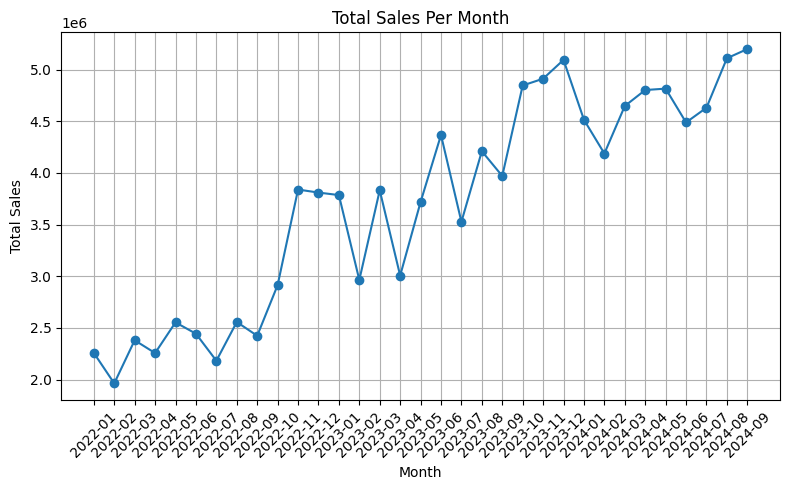

In [7]:
import matplotlib.pyplot as plt

# Group the data by 'YearMonth' and sum the 'Total Sales'
monthly_sales = grouped.groupby('YearMonth')['Total Sales'].sum().reset_index()

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(monthly_sales['YearMonth'].astype(str), monthly_sales['Total Sales'], marker='o')

plt.title('Total Sales Per Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Prepare the DataFrame for the specific item IDs
study_data = grouped[grouped['Itemcode'].isin(study_items)]
# Pivot the data to get sales for each item in separate columns
pivot_data = study_data.pivot(index='YearMonth', columns='Itemcode', values='Total Sales').fillna(0)





pivot_data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


# Function to create sequences for time series data
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Define the number of time steps
time_steps = len(pivot_data) // 10

# Create sequences
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(pivot_data)
X, y = create_sequences(scaled_data, time_steps)

print(X.shape)
print(y.shape)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout , Flatten



# Build complex LSTM model

# Build a simplified LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))  # Single LSTM layer
model.add(Dense(y.shape[1]))
model.compile(optimizer='adam', loss='mse')

# Train the model quietly
model.fit(X, y, epochs=100, batch_size=64 , verbose = 0)


In [ ]:

# Make predictions
y_pred = model.predict(X)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_true_inverse = scaler.inverse_transform(y)

# Plot the actual vs. predicted sales for a specific item ID
item_id = study_item[3]  # Choose the first item ID for demonstration
item_index = np.where(pivot_data.columns == item_id)[0][0]

plot_index = pivot_data.index.astype(str).values

plt.figure(figsize=(12, 6))
plt.plot(plot_index[time_steps:], y_true_inverse[:, item_index], label='Actual Sales')
plt.plot(plot_index[time_steps:], y_pred_inverse[:, item_index], label='Predicted Sales', linestyle='--')
plt.title(f'Sales Prediction for Item ID: {item_dict[item_id]}')
plt.xlabel('YearMonth')
plt.ylabel('Total Sales')
plt.legend()
plt.xticks(rotation=90)
# Add last prediction value as text annotation
last_pred_value = y_pred_inverse[-1, item_index]
plt.text(plot_index[-1], last_pred_value, f'{last_pred_value:.2f}', color='red')
plt.show()

In [ ]:
# Get the last predictions for all items
last_predictions = y_pred_inverse[-1]

last_pred_df = pd.DataFrame({
    'Itemcode': pivot_data.columns,
    'Last Prediction': last_predictions
})

last_pred_df['Item Description'] = last_pred_df['Itemcode'].map(item_dict)

last_pred_df['Last Prediction'] = last_pred_df['Last Prediction'].astype(float).round(2)
# Move the 'Last Prediction' column to the end
last_pred_df = last_pred_df[['Itemcode', 'Item Description', 'Last Prediction']]


# Save the DataFrame to an Excel file
last_pred_df.to_excel('last_predictions.xlsx', index=False)
last_pred_df


In [ ]:
# Make predictions
y_pred = model.predict(X)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_true_inverse = scaler.inverse_transform(y)

# Prepare future periods for the next three months using pd.Period methods
last_date = pd.Period(pivot_data.index[-1], freq='M')
future_dates = [last_date + i for i in range(1, 4)]

# Make predictions for the next three months
future_predictions = []
current_data = scaled_data[-time_steps:]  # Start with the latest available data

for _ in future_dates:
    current_data = current_data.reshape((1, time_steps, X.shape[2]))
    next_prediction = model.predict(current_data)
    future_predictions.append(next_prediction.flatten())

    # Update current data by appending the new prediction and removing the oldest data point
    current_data = np.append(current_data[:, 1:, :], next_prediction.reshape((1, 1, X.shape[2])), axis=1)

# Inverse scale the future predictions
future_predictions = scaler.inverse_transform(future_predictions)

# Create a DataFrame for the future predictions
future_pred_df = pd.DataFrame(future_predictions, columns=pivot_data.columns, index=future_dates)
future_pred_df.index.name = 'YearMonth'

# Combine actual and future predictions for plotting
combined_index = np.concatenate([plot_index, future_pred_df.index.astype(str).values])

# Plot the actual vs. predicted sales for a specific item ID
item_id = study_item[100]  # Choose the specific item ID for demonstration
item_index = np.where(pivot_data.columns == item_id)[0][0]

plt.figure(figsize=(12, 6))
plt.plot(plot_index[time_steps:], y_true_inverse[:, item_index], label='Actual Sales')

plt.plot(np.concatenate([plot_index[time_steps:], future_pred_df.index.astype(str).values]),
         np.concatenate([y_pred_inverse[:, item_index], future_pred_df.iloc[:, item_index]]),
         label='Predicted Sales', linestyle='--')

plt.title(f'Sales Prediction for Item ID: {item_dict[item_id]}')
plt.xlabel('YearMonth')
plt.ylabel('Total Sales')
plt.legend()
plt.xticks(rotation=90)



# Add future prediction values as text annotations
for date, value in zip(future_pred_df.index.astype(str).values, future_pred_df.iloc[:, item_index]):
    plt.text(date, value, f'{value:.2f}', color='blue')

plt.show()


In [ ]:

# Pivot the DataFrame to make columns as rows
pivot_future_pred_df = future_pred_df.transpose()


pivot_future_pred_df